# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

Group 15: William Jones, Elliot Leishman, Tristan Pang and Aidan Garrity

## General Setup

In [92]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

In [170]:
# Load data
data = pd.read_csv("the_office.csv")


After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

In [94]:
# load additional data [1]
data_lines = pd.read_csv("the-office-lines.csv")

# remove deleted scenes
data_lines = data_lines[~data_lines.deleted]

# get number of scenes per episode
n_scenes = data_lines.groupby(['season', 'episode'])['scene'].max()

# add number of scenes per episode to our dataframe
data['n_scenes'] = np.array(n_scenes)

# add count column to dataframe
data_lines['n_lines'] = 1

# [1] The Office lines 
# AUTHOR: Abhinav Ralhan
# URL: https://data.world/abhinavr8/the-office-scripts-dataset
# DATE  CREATED: 12/05/2018
# ACCESSED: 28/02/2023

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

### 2.1 A brief overview of the data

In [134]:
# Investigate the datatypes of the dataset
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


None

The first output shows that our dataset contains 186 rows (observations) with 13 columns, we have already identified 'imdb_rating' as our output thus leaving us with 12 features. The non-null count column tells us we have no null values in our dataset, therefore no cleaning regarding null values is needed. Seven of our columns are of datatype 'int64', checking the corresponding columm names, storing these values as an integer seems sensible and no manipultion of these data features is necessary. There is one feature of datatype 'float64', namely 'imdb_rating', this is an appropriate datatype because IMDB report there rating with an accuracy of 1 decimal place. Finally, we have five features of datatype 'object', these features will be given special consideration further in this section. 

At this point it is important to remeber the brief of our task 'to advise what NBC Universal should do to produce the highest rated reunion episode possible'. Therefore there is no point to include information considering season number and episode number in our model as our reunion episode will not fit into the standard seasons format of the regular episodes. Furthermore, we will not consider 'air_date' in our model as this is not a relevent feature since this episode will air significantly after the official finale in 2013. The final feature we will omit from our model at this stage is 'episode_name' because these are unique strings and will be decided based off of the episodes content. 

In [135]:
# Exploration of Numeric Features - Should we have already dropped season, episode etc.? Or add Box plots in here?

# Print summary statistics for numeric features - rounded to 2 decimal places.
display(data.describe().round(2))

,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char
count,186.00,186.00,186.00,186.00,186.00,186.00,186.00,186.00
mean,5.46,12.48,8.25,2129.54,296.40,50.15,3053.51,20.69
std,2.40,7.23,0.54,790.79,82.00,23.94,799.27,5.09
min,1.00,1.00,6.70,1393.00,131.00,11.00,1098.00,12.00
25%,3.00,6.00,7.90,1628.50,255.25,34.00,2670.25,17.00
50%,6.00,12.00,8.20,1954.00,281.00,46.00,2872.50,20.00
75%,7.75,18.00,8.60,2385.00,314.50,60.00,3141.00,23.00
max,9.00,28.00,9.70,7934.00,625.00,166.00,6076.00,54.00


Is this above really Necessary in Final report?

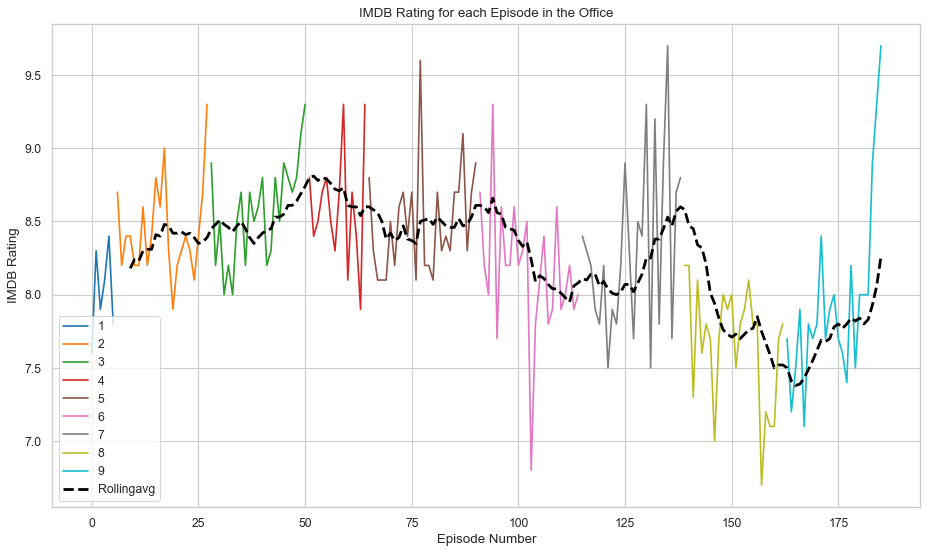

In [174]:
data_indexed = data.reset_index()
cmap = plt.get_cmap("tab10")
sns.set_style(style= 'whitegrid')
sns.lineplot(data = data_indexed, x = 'index', y = 'imdb_rating', hue = 'season', palette= cmap, legend = 'full')
data_indexed[ '10ep_rolling_avg' ] = data_indexed.imdb_rating.rolling(10).mean()
sns.lineplot( x = 'index', y = '10ep_rolling_avg', data = data_indexed, label = 'Rollingavg', linestyle='dashed', color = 'black', linewidth = 2.5)
plt.title('IMDB Rating for each Episode in the Office')
plt.xlabel('Episode Number')
plt.ylabel('IMDB Rating')
plt.show()



Although this figure does not provide the most in-depth insights into each episode, it does allow us an overview of the general trend in IMDB rating as the show progressed as well as hightlighting potential outliers in the dataset. In regard to overall trend, consulting the rolling average of the previous 10 episodes, we can clearly see the show experienced a slow and steady increase in ratings throughout the first three seasons. This is most likely due to the show finding its feet and developing its own identity. The shows ratings appear relatively stable throughout the next 4 seasons except a small dip towards the end of season 6 and continuing into the beginning of season 7. It is season 8 where the show experienced its biggest decline in ratings, this could be due to many factors, such as the show losing creativity in writing/ directing or a shake-up in the cast members. Interestingly, the shows ratings increased into the final season, and continued on an upward trajectory thorughout the season, perhaps due to nostalgia. Other trends we can see from the figure is importance of the season finale. Note that in seasons 2,3,4 and 9, the season finale appears to be the highest rated episode in the season. This could be due to the payoff of several theme and character arcs from the season.

An interesting outlier is the episode in season 6 with a rating of less than 7, although this is not the lowest rated episode in the series, it is clearly the epsiode with rating furthest away in the negative direction from the rolling average. [EXPLANATION BY SOMEONE ELSE PLZ!]... 

In [124]:
# Drop irrelevant columns
data = data.drop(columns=['index', 'season', 'episode', 'episode_name', 'air_date', 'total_votes'])

### 2.2 Correlation 

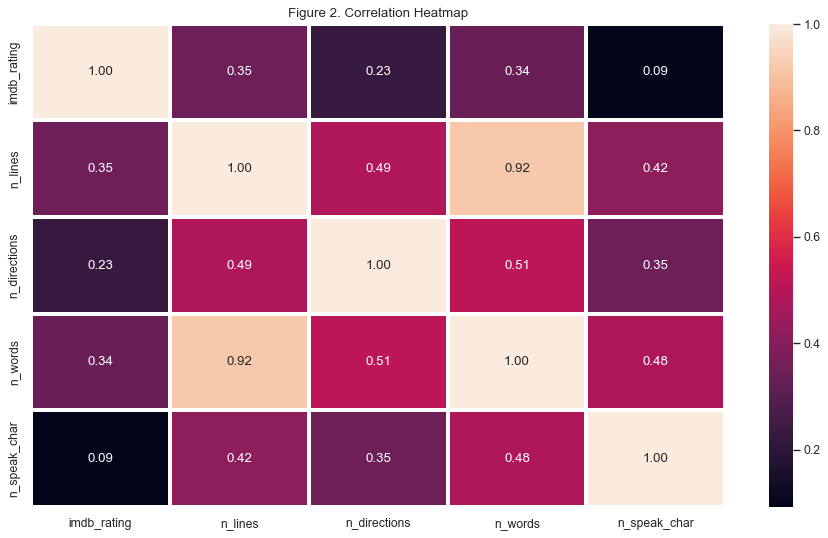

In [125]:
sns.set(rc={'figure.figsize': (14, 8)})

# Correlation heatmap 
sns.heatmap(data.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Figure 2. Correlation Heatmap")
plt.show()

# Correlation pairplot
# sns.pairplot(data, hue = 'writer')

We see that 'n_words' and 'n_lines' have a strong, positive correlation, therefore we may want to only include one in our model to reduce the workload.

The next highest postive correlation is between 'total_votes' and 'imbd_rating'. Since imdb rating is what we want to maximise we would expect our model to also 

### 2.3 Diagnostic Plots

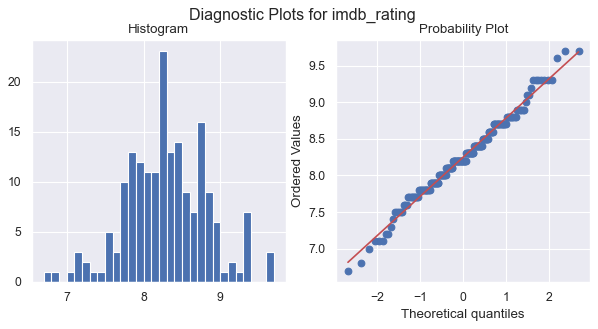

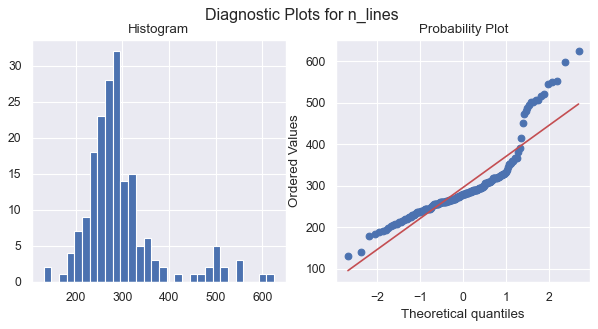

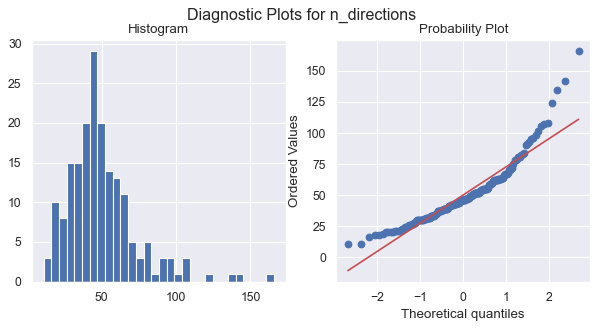

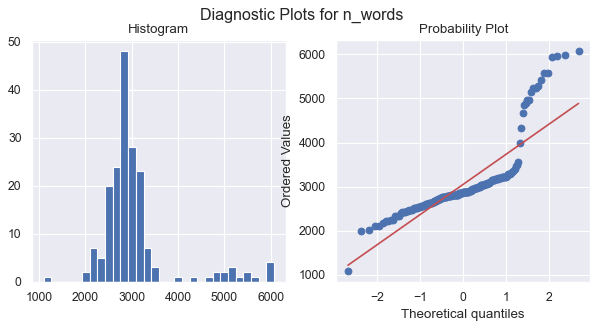

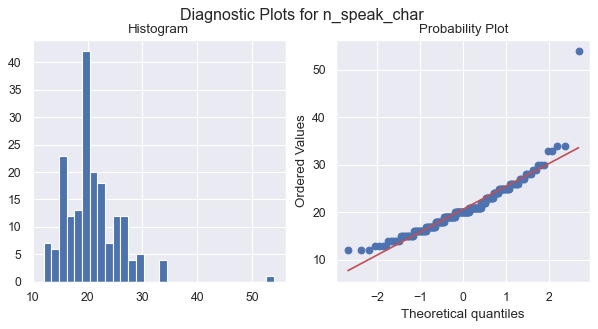

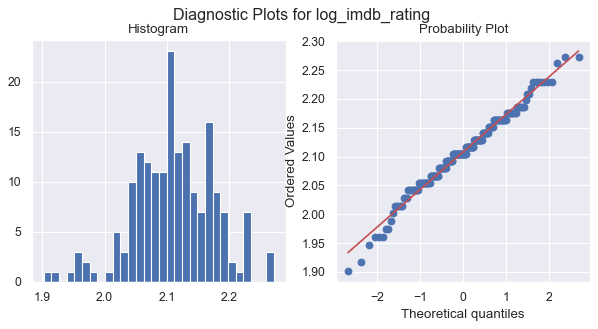

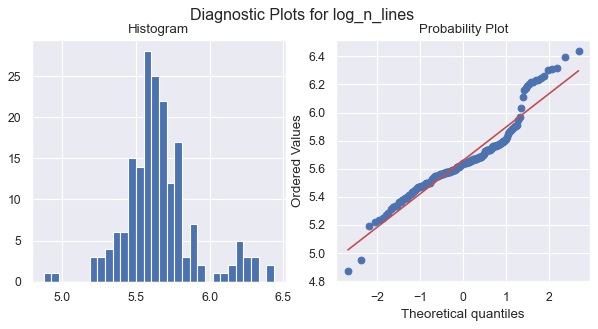

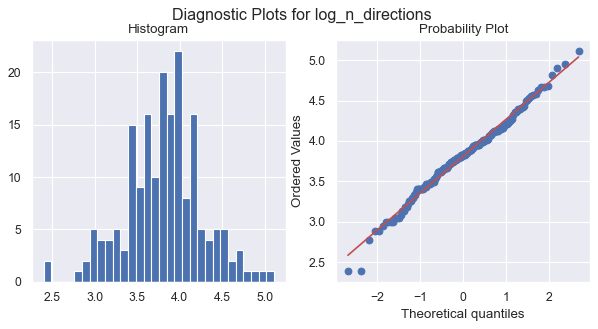

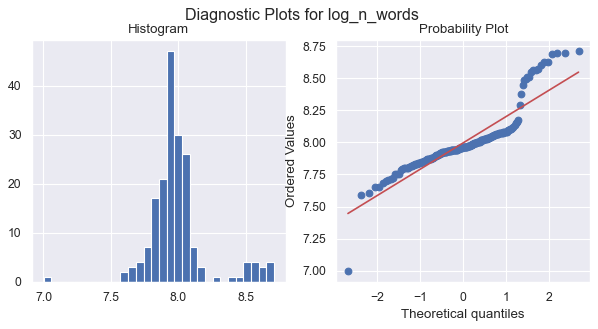

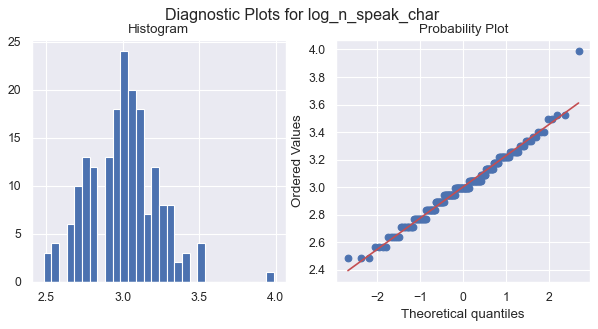

In [126]:
# Distributions - from Python Feature Engineering Cookbook
def diagnostic_plots(df, variable): 
    plt.figure(figsize=(9,4)) 
    plt.subplot(1, 2, 1) 
    df[variable].hist(bins=30)
    plt.title("Histogram")
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt) 
    plt.suptitle("Diagnostic Plots for {}".format(variable))
    plt.show()

for variable_name in data.select_dtypes(exclude = 'object'): # excludes columns with data type object, i.e. only investigate numeric values
    data[f'log_{variable_name}']=np.log(data[variable_name])
for variable_name in data.select_dtypes(exclude = 'object'): # excludes columns with data type object, i.e. only investigate numeric values
    diagnostic_plots(data, variable_name)

Note that imbd rating and n_speak_char are 'close' to being normally distributed

0      Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1      Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2      Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3      Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4      Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...
                             ...                        
181    Andy;Angela;Creed;Dwight;Erin;Jim;Kevin;Meredi...
182    Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
183    Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
184    Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
185    Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly...
Name: main_chars, Length: 186, dtype: object


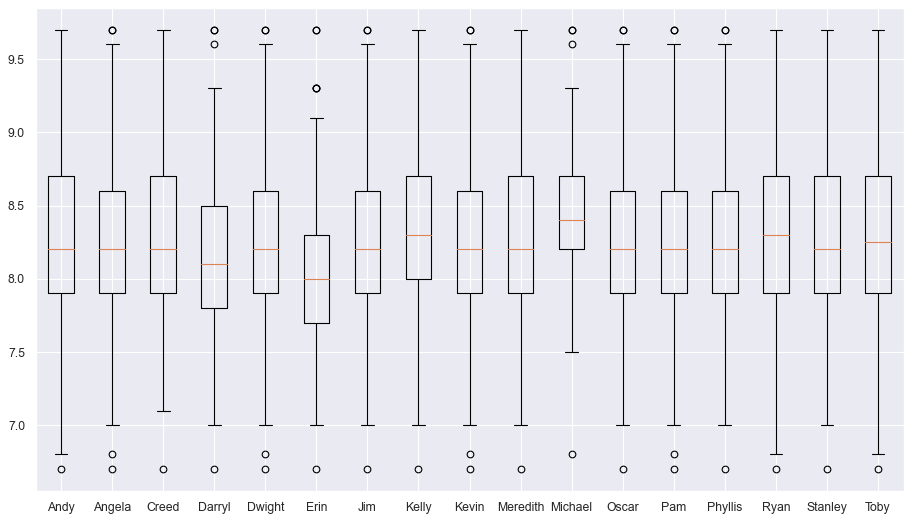

In [129]:
# Investigating effect of characters on imdb rating
chars = data['main_chars']
chars = chars.str.split(';', expand = False)
chars = pd.get_dummies(chars.apply(pd.Series).stack()).sum(level=0)

chars2 = pd.merge(data['imdb_rating'], chars, left_index=True, right_index=True)

plotting=[]
for character in chars:
    condition = character + '==1'
    plotting.append(chars2.query(condition)['imdb_rating'])
plt.boxplot(plotting)
plt.xticks(np.arange(1,18), chars.columns)
plt.show()

In [ ]:
chars2.sort_values(by = ['imdb_rating'])

,imdb_rating,Andy,Angela,Creed,Darryl,Dwight,Erin,Jim,Kelly,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby
157,6.7,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
103,6.8,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1
146,7.0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0
160,7.1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,0
167,7.1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,9.3,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,0
59,9.3,1,1,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0
77,9.6,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0
135,9.7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


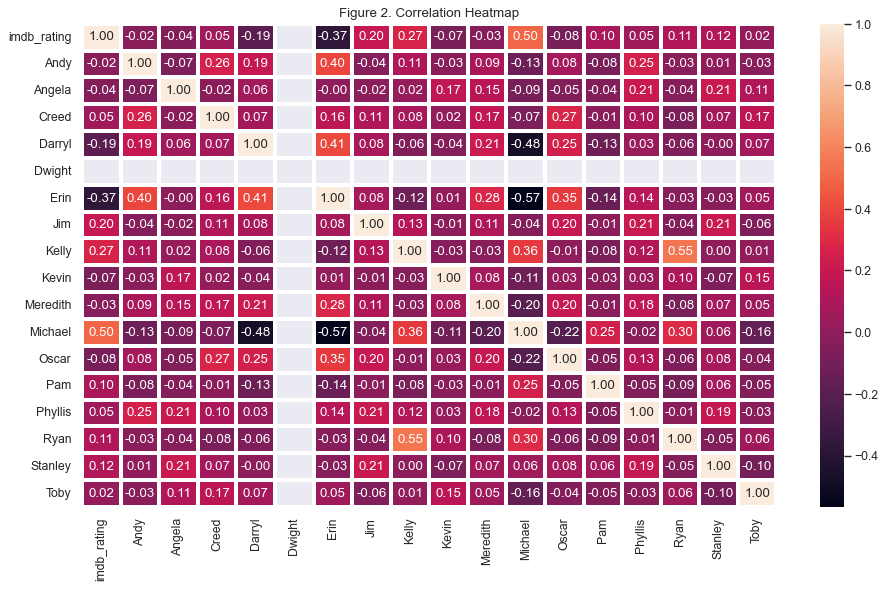

Andy        143
Angela      171
Creed       131
Darryl      105
Dwight      186
Erin         98
Jim         185
Kelly       142
Kevin       180
Meredith    131
Michael     137
Oscar       164
Pam         182
Phyllis     165
Ryan        139
Stanley     165
Toby        108
dtype: int64

In [ ]:
# Correlation
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(chars2.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Figure 2. Correlation Heatmap")
plt.show()
chars.sum()

## Writers

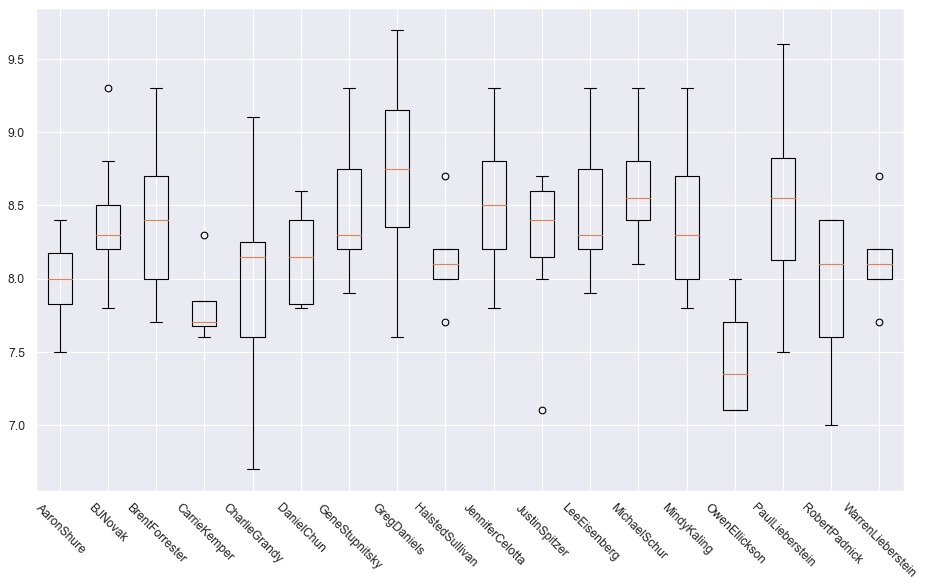

In [ ]:
def split_names(column, minimum = -np.inf, df=data):
    '''
    Split names in a specific column by `;` and ignore other puntuation.
    '''
    # Retrieve data 
    data_column = (df[column]).copy()
    
    # Remove punctuation
    for punc in [' ', '.', '-']:
        data_column = data_column.str.replace(punc,'')
    
    # Split
    data_column = data_column.str.split(';',expand=False)
    
    allwriters = [item for sublist in data_column.to_list() for item in sublist].copy()
    writersepisodes = {x: allwriters.count(x) for x in allwriters}.copy()
    #print(writersepisodes)
    new_data_column = []
    for episode in data_column:
        new_episode = []
        for contributor in episode:
            if writersepisodes[contributor] > minimum:
                new_episode.append(contributor)
        if episode == []:
            new_episode.append('Other')
        new_data_column.append(new_episode)
    new_data_column = pd.Series(new_data_column)
    data_column = pd.get_dummies(new_data_column.apply(pd.Series).stack()).sum(level=0)

    return data_column.copy()

writers = split_names('writer', minimum=3)
writers2 = pd.merge(data['imdb_rating'], writers, left_index=True, right_index=True)

plotting=[]
for writer in writers:
    condition = writer + '==1'
    plotting.append(writers2.query(condition)['imdb_rating'])
plt.boxplot(plotting)
plt.xticks(np.arange(1,len(writers.columns)+1), writers.columns)
plt.xticks(rotation = 315)
plt.show()

## Directors

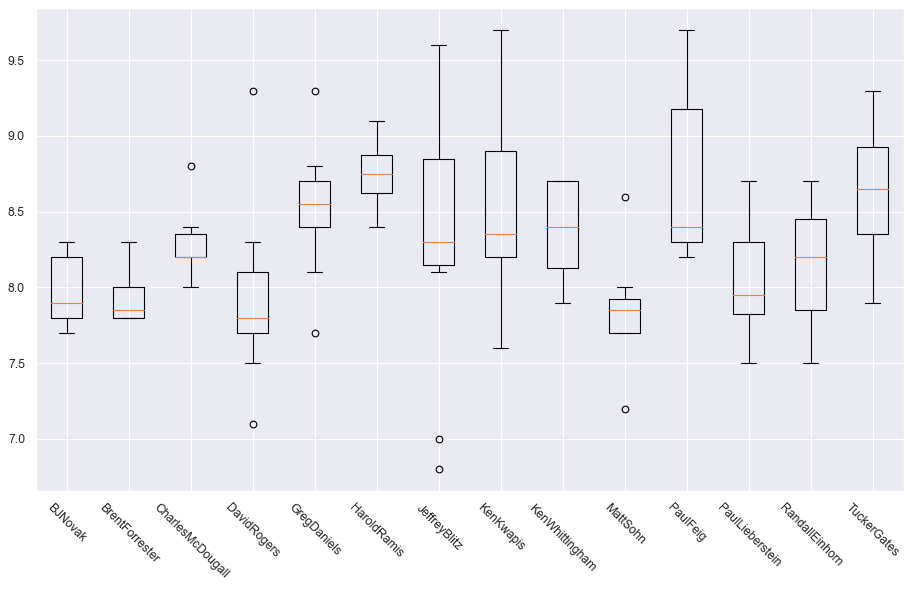

In [ ]:
directors = split_names('director', minimum=3)
directors2 = pd.merge(data['imdb_rating'], directors, left_index=True, right_index=True)

plotting=[]
for director in directors:
    condition = director + '==1'
    plotting.append(directors2.query(condition)['imdb_rating'])
plt.boxplot(plotting)
plt.xticks(np.arange(1,len(directors.columns)+1), directors.columns)
plt.xticks(rotation = 315)
plt.show()

## Characters

In [ ]:
reindex_df = pd.DataFrame(data_lines.groupby(['season', 'episode']).sum()).reset_index()

#reindex_df.query(f'season==1 and episode==1').index[0]
data_lines['total_episode']=0
for total_episode in reindex_df.index:
    s, e = reindex_df[['season','episode']].loc()[total_episode]
    index = [(data_lines['season']==s) & (data_lines['episode']==e)]
    data_lines['total_episode']=data_lines['total_episode']+(np.array(index)*total_episode)[0]

display(data_lines)

,id,season,episode,scene,line_text,speaker,deleted,n_lines,total_episode
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False,1,0
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False,1,0
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False,1,0
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False,1,0
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False,1,0
...,...,...,...,...,...,...,...,...,...
59904,59905,9,23,112,It all seems so very arbitrary. I applied for ...,Creed,False,1,185
59905,59906,9,23,113,I just feel lucky that I got a chance to share...,Meredith,False,1,185
59906,59907,9,23,114,I���m happy that this was all filmed so I can ...,Phyllis,False,1,185
59907,59908,9,23,115,I sold paper at this company for 12 years. My ...,Jim,False,1,185


In [ ]:
main_chars = data['main_chars']
main_chars = main_chars.str.split(';')
main_chars = list(main_chars.apply(pd.Series).stack().unique())

n_lines_character = data_lines.groupby(['total_episode', 'speaker'])['n_lines'].sum()
n_lines_character = n_lines_character.reset_index()
n_lines_character = n_lines_character[n_lines_character['speaker'].isin(main_chars)]
n_lines_character = n_lines_character.reset_index()

n_lines_character = n_lines_character.pivot(index='total_episode',columns='speaker',values='n_lines').fillna(0)

display(n_lines_character)

speaker,Andy,Angela,Creed,Darryl,Dwight,Erin,Jim,Kelly,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby
total_episode,,,,,,,,,,,,,,,,,
0,0.0,1.0,0.0,0.0,29.0,0.0,36.0,0.0,1.0,0.0,81.0,3.0,41.0,2.0,8.0,5.0,0.0
1,0.0,4.0,0.0,0.0,19.0,0.0,27.0,2.0,8.0,0.0,81.0,13.0,16.0,0.0,4.0,5.0,2.0
2,0.0,5.0,0.0,0.0,62.0,0.0,42.0,0.0,6.0,3.0,56.0,9.0,32.0,0.0,1.0,6.0,0.0
3,0.0,7.0,0.0,0.0,58.0,0.0,49.0,0.0,3.0,10.0,79.0,14.0,22.0,5.0,4.0,2.0,4.0
4,0.0,3.0,0.0,15.0,26.0,0.0,22.0,0.0,1.0,0.0,106.0,2.0,14.0,4.0,8.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,31.0,4.0,2.0,0.0,61.0,10.0,15.0,0.0,5.0,2.0,0.0,7.0,9.0,5.0,0.0,21.0,15.0
182,39.0,16.0,1.0,10.0,21.0,16.0,17.0,0.0,10.0,0.0,0.0,2.0,22.0,0.0,0.0,2.0,7.0
183,68.0,30.0,2.0,11.0,54.0,9.0,63.0,0.0,13.0,1.0,0.0,19.0,30.0,4.0,0.0,4.0,7.0


## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

<span style="color:red">
I believe the plan is to use LASSO regression as it will perform feature selection which will improve interpretability.

'Ridge regression is useful when there is a concern about multicollinearity, and Lasso regression is useful when there are many predictors and some are suspected to be irrelevant or have little effect on the outcome.'

Should we use Cross-Validation to reduce variability in model fit and hence validation error?

A proposal for a general section plan:

    - Start with a simple general linear model with all the shit in it. We can use this as a baseline to show we are justified in making a more complicated model.
    - Make a LASSO model to get rid of un-necessary features
    - Maybe look into nonlinear or polynomial regression?

Other General things:

    - Should we consider named character in the main model, or should we instead, predict best number of characters and then try to find which characters they should be?
    - Should probably use the annoying SKlearn pipelines 
    - Comment code @Tristan Pang



Finally dont forget to 'regress the regression',

Your captian.

</span>

Import the get_coefs and model_fit functions from Workshop 5. This will allow us to evaluate our model fit and stuff.

In [ ]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [ ]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [ ]:
# Splitting into test and train data
from sklearn.model_selection import train_test_split
people = n_lines_character.join(writers)
display(people)
X = data.drop('imdb_rating', axis = 1) # Set of features
X_ = pd.merge(X, people, left_index=True, right_index=True)

y = data['imdb_rating']

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.10)
#X_test.head()

,Andy,Angela,Creed,Darryl,Dwight,Erin,Jim,Kelly,Kevin,Meredith,...,JustinSpitzer,LeeEisenberg,MichaelSchur,MindyKaling,Other,OwenEllickson,PaulLieberstein,RobertPadnick,StephenMerchant,WarrenLieberstein
total_episode,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,0.0,0.0,29.0,0.0,36.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,4.0,0.0,0.0,19.0,0.0,27.0,2.0,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,5.0,0.0,0.0,62.0,0.0,42.0,0.0,6.0,3.0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,7.0,0.0,0.0,58.0,0.0,49.0,0.0,3.0,10.0,...,0,0,1,0,0,0,0,0,0,0
4,0.0,3.0,0.0,15.0,26.0,0.0,22.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,31.0,4.0,2.0,0.0,61.0,10.0,15.0,0.0,5.0,2.0,...,0,0,0,0,1,0,0,0,0,0
182,39.0,16.0,1.0,10.0,21.0,16.0,17.0,0.0,10.0,0.0,...,0,0,0,0,0,0,0,0,0,1
183,68.0,30.0,2.0,11.0,54.0,9.0,63.0,0.0,13.0,1.0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Linear regression - move to top?
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Define headers to regress on
head0 = [ 'n_lines', 'n_directions', 'n_words', 'n_speak_char']

head = list(people.keys()) + head0

# get regressing cols
X_train_ = X_train[head]
X_test_ = X_test[head]

# regress the regression 
test_model = LinearRegression()
test_model.fit(X_train_,y_train)

# use the regressed regression to predict
y_train_pred = test_model.predict(X_train_)
y_test_pred = test_model.predict(X_test_)

# Rsquared
print(r'Train $R^2$', r2_score(y_train, y_train_pred))
print(r'Test $R^2$', r2_score(y_test, y_test_pred))

# coefficients of regression
print(test_model.intercept_)
coeffs = pd.DataFrame(test_model.coef_, head, columns=['Coefficients'])
coeffs

Train $R^2$ 0.4921218516092637
Test $R^2$ -0.30414040181392155
7.34527821903794


,Coefficients
Andy,-0.002484
Angela,0.007145
Creed,0.006897
Darryl,-0.001008
Dwight,0.000795
Erin,-0.005260
Jim,0.001088
Kelly,-0.005426
Kevin,0.003453
Meredith,0.007517


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.model_selection import LeaveOneOut
# Define headers to regress on
head0 = ['n_lines', 'n_directions', 'n_words', 'n_speak_char']
head = list(people.keys()) + head0

# get regressing cols
X_train_ = X_train[head]
X_test_ = X_test[head]

# regress the regression 
lasso_model = make_pipeline(
    #PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
    RFECV(LinearRegression(), step=1, cv=len(X_train_)-1),
    #LeaveOneOut(),
    Lasso(alpha=1)
    ).fit(X_train_, y_train)

# use the regressed regression to predict
y_train_pred = test_model.predict(X_train_)
y_test_pred = test_model.predict(X_test_)

# Rsquared
print(r'Train $R^2$', r2_score(y_train, y_train_pred))
print(r'Test $R^2$', r2_score(y_test, y_test_pred))

# coefficients of regression
print(lasso_model.named_steps['lasso'].intercept_)
lasso_model.named_steps['lasso'].coef_

ranking=pd.DataFrame([lasso_model.named_steps['rfecv'].ranking_, head]).transpose().sort_values(by=0)

ranking

Train $R^2$ 0.4921218516092637
Test $R^2$ -0.30414040181392155
8.252694610778443


,0,1
33,1,OwenEllickson
36,2,StephenMerchant
25,3,GregDaniels
30,4,MichaelSchur
34,5,PaulLieberstein
29,6,LeeEisenberg
31,7,MindyKaling
19,8,BrentForrester
18,9,BJNovak
27,10,JenniferCelotta


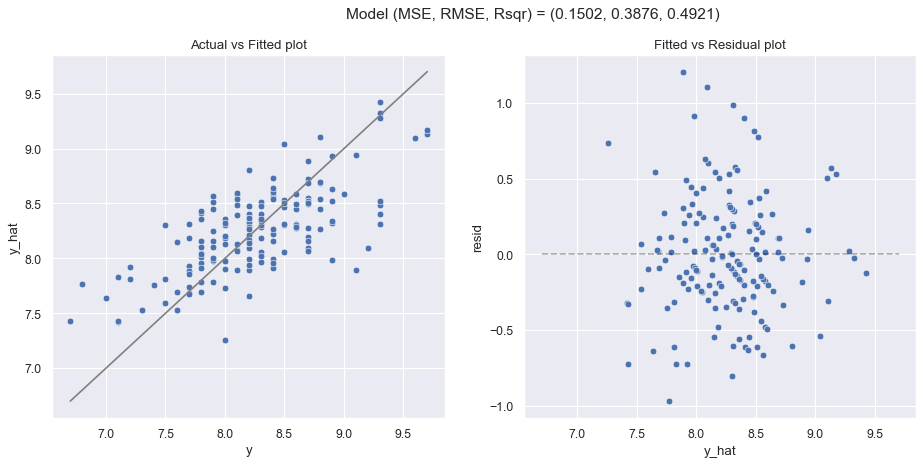

[ 7.34527822e+00 -2.48364360e-03  7.14468592e-03  6.89736295e-03
 -1.00763896e-03  7.95017438e-04 -5.26026219e-03  1.08785138e-03
 -5.42611599e-03  3.45319565e-03  7.51680083e-03  3.81796864e-03
 -3.16048036e-03  6.81652115e-04  1.98476420e-03  1.39367649e-03
  5.24103940e-03 -1.49287264e-03 -2.05285122e-01  2.53024315e-01
  1.61529347e-01 -8.46288879e-02 -1.71844398e-01  1.54320751e-01
 -9.04992557e-04  1.10875153e-01  3.91619495e-01  7.92068033e-02
 -3.55868196e-02  1.92157071e-01  1.10875153e-01  3.44818860e-01
  1.48539422e-01  3.34834646e-02 -3.05119926e-01  1.95215806e-01
  1.56278029e-02 -3.62964115e-01  7.92068033e-02 -1.41375547e-04
  3.64753528e-03  6.36356265e-05  5.91964864e-03]


In [ ]:
model_fit(test_model, X_train_, y_train, plot = True)
print(get_coefs(test_model))



In [ ]:
# Tristans code but without character names

# Define headers to regress on
head = ['total_votes', 'n_lines', 'n_directions', 'n_words', 'n_speak_char']

# get regressing cols
X_train_ = X_train[head]
X_test_ = X_test[head]

# regress the regression 
test_model = LinearRegression()
test_model.fit(X_train_,y_train)

# use the regressed regression to predict
y_train_pred = test_model.predict(X_train_)
y_test_pred = test_model.predict(X_test_)

# Rsquared
print(r'Train $R^2$', r2_score(y_train, y_train_pred))
print(r'Test $R^2$', r2_score(y_test, y_test_pred))

model_fit(test_model, X_train_, y_train, plot = True)
print(get_coefs(test_model))

KeyError: "['total_votes'] not in index"

In the first model, the points in the actual vs fitted plot are much closer to the fitted line than the second mode, suggesting it is indeed better. For both residual plots the points seem to be equally distributed about 0, suggesting linearity assumption is indeed reasonable. Some points are quite far away from the 0 line suggesting the model struggles to deal with outliers, however this is slightly better in first plot. Finally R^2 value of first plot is better as well as MSE and RMSE.

In [ ]:
plt.plot(coeffs,'o')
plt.xticks(rotation=45)

plt.plot(head,[0]*len(head), label='0')

#plt.yscale('symlog')

plt.legend()
plt.ylabel('Regression Coefficients')
plt.xlabel('Features')
plt.show()


## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from

stackexchange

chatGPT

Tristan Pang
